In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output
from tqdm.auto import tqdm
from torchvision.utils import make_grid

sys.path.append('..')
sns.set()

In [2]:
from models import gaussian_sample
from models.flows import Glow
from models.kd_flows import GlowGetAllOutputs
from data.src import get_CelebA
from data.src import postprocess

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Celeba

In [4]:
from torch.utils.data import DataLoader

In [5]:
image_shape, num_classes, train_dataset, test_dataset = get_CelebA(
    augment=True,
    dataroot='/home/vdklyukin/nf_distillation/data',
    download=True,
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
student_params = {
    "is_1d": False,
    "image_shape": [64, 64, 3],
    "hidden_channels": 256,
    "K": 16,
    "L": 3,
    "actnorm_scale": 1.0,
    "flow_permutation": "invconv",
    "flow_coupling": "affine",
    "LU_decomposed": True,
    "y_classes": 40,
    "learn_top": False,
    "y_condition": False,
}
teacher_params = {
    "is_1d": False,
    "image_shape": [64, 64, 3],
    "hidden_channels": 512,
    "K": 32,
    "L": 3,
    "actnorm_scale": 1.0,
    "flow_permutation": "invconv",
    "flow_coupling": "affine",
    "LU_decomposed": True,
    "y_classes": 40,
    "learn_top": False,
    "y_condition": False,
}

student_checkpoint = "/home/vdklyukin/nf_distillation/outputs/2021-04-20/10-47-08/"\
                     "distillation/NF-496/checkpoints/epoch=213-step=544415.ckpt"
student_kd_checkpoint = "/home/vdklyukin/nf_distillation/outputs/2021-04-19/19-09-29/"\
                        "distillation/NF-495/checkpoints/epoch=180-step=460463.ckpt"
teacher_checkpoint = "/home/vdklyukin/nf_distillation/outputs/2021-04-15/12-27-00/"\
                     "distillation/NF-462/checkpoints/epoch=53-step=274697.ckpt"

In [7]:
student = GlowGetAllOutputs(**student_params).to(device)
student_kd = GlowGetAllOutputs(**student_params).to(device)
teacher = GlowGetAllOutputs(**teacher_params).to(device)

In [8]:
def preprocess_state(state):
    return {
        ".".join(k.split(".")[1:]): v
        for k, v in state["state_dict"].items()
        if k.startswith("student.")
    }

In [9]:
student_state = preprocess_state(torch.load(student_checkpoint))
student_kd_state = preprocess_state(torch.load(student_kd_checkpoint))
teacher_state = preprocess_state(torch.load(teacher_checkpoint))

student.load_state_dict(student_state)
student_kd.load_state_dict(student_kd_state)
teacher.load_state_dict(teacher_state)

<All keys matched successfully>

In [10]:
student.set_actnorm_init()
student_kd.set_actnorm_init()
teacher.set_actnorm_init()

student.eval()
student_kd.eval()
teacher.eval()

GlowGetAllOutputs(
  (flow): FlowNetGetAllOutputs(
    (layers): ModuleList(
      (0): SqueezeLayer()
      (1): FlowStep(
        (actnorm): ActNorm2d()
        (invconv): InvertibleConv1x1()
        (block): Sequential(
          (0): Conv2d(
            (padder): ZeroPad2d(padding=[1, 1, 1, 1], value=0.0)
            (conv): Conv2d(6, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
            (actnorm): ActNorm2d()
          )
          (1): ReLU()
          (2): Conv2d(
            (padder): ZeroPad2d(padding=[0, 0, 0, 0], value=0.0)
            (conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (actnorm): ActNorm2d()
          )
          (3): ReLU()
          (4): Conv2dZeros(
            (padder): ZeroPad2d(padding=[1, 1, 1, 1], value=0.0)
            (conv): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1))
          )
        )
      )
      (2): FlowStep(
        (actnorm): ActNorm2d()
        (invconv): InvertibleConv1x1()
        (blo

In [11]:
NUM_SAMPLES = 10000

In [24]:
@torch.no_grad()
def interpolate_latent(model, x):
    z, _, _ = model(x, None)
    z = z[-1]
    
    norms = torch.norm(z.view(x.size(0), -1), dim=1)
    alpha = torch.rand(z.size(0) // 2, 1, 1, 1, device=device)
#     alpha = torch.zeros(z.size(0) // 2, 1, 1, 1, device=device)
    interpolation = z[::2] * alpha + z[1::2] * (1 - alpha)
    interpolation_norm = torch.norm(interpolation.view(x.size(0) // 2, -1), dim=1)
    alpha = alpha.view(-1)
    interpolation *= ((norms[::2] * alpha + norms[1::2] * (1 - alpha)) \
                      / interpolation_norm).view(-1, 1, 1, 1)
    return interpolation
    
@torch.no_grad()
def generate(model, z, temperature=1):
    return postprocess(
        model(
            z=z, temperature=temperature, reverse=True
        )[-1]
    ).detach() \
     .cpu()

  0%|          | 0/310 [00:00<?, ?it/s]

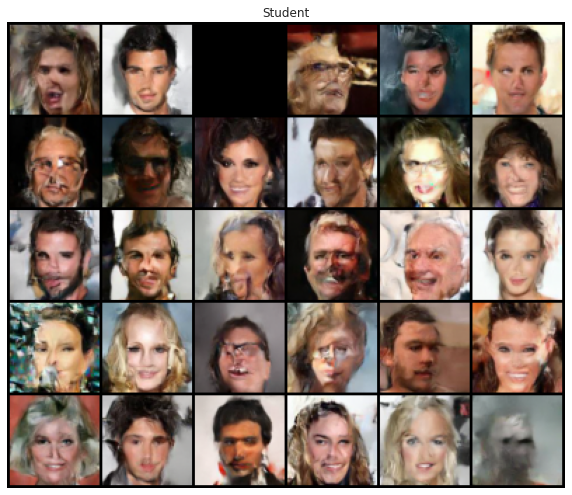

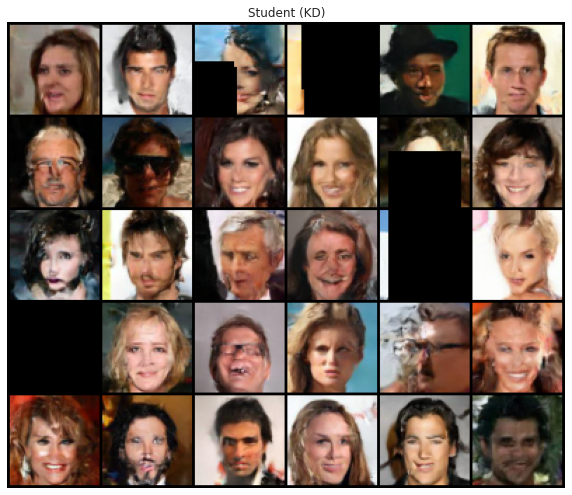

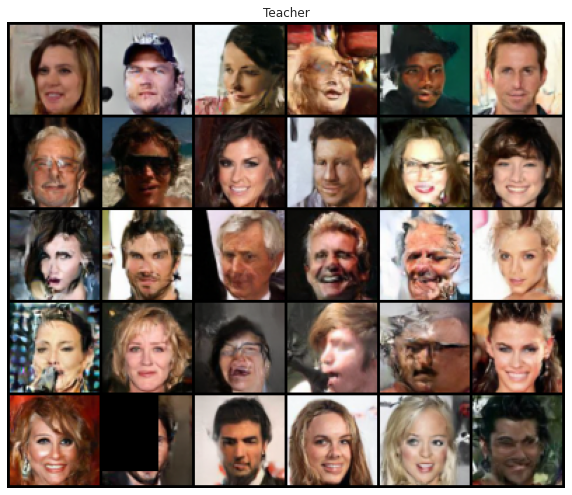

In [13]:
cur_samples = 0

samples = defaultdict(list)

for x, _ in tqdm(test_loader):
    x = x.to(device)
    student_latents = interpolate_latent(student, x)
    student_kd_latents = interpolate_latent(student_kd, x)
    teacher_latents = interpolate_latent(teacher, x)
    
    student_samples = generate(student, student_latents)
    student_kd_samples = generate(student_kd, student_kd_latents)
    teacher_samples = generate(teacher, teacher_latents)
    
    samples["student"].append(student_samples)
    samples["student_kd"].append(student_kd_samples)
    samples["teacher"].append(teacher_samples)
    
    cur_samples += x.size(0) // 2
    if cur_samples >= NUM_SAMPLES:
        break

grid = make_grid(student_samples[:30], nrow=6).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.title("Student")
plt.imshow(grid)
plt.axis("off")
plt.show()

grid = make_grid(student_kd_samples[:30], nrow=6).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.title("Student (KD)")
plt.imshow(grid)
plt.axis("off")
plt.show()

grid = make_grid(teacher_samples[:30], nrow=6).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.title("Teacher")
plt.imshow(grid)
plt.axis("off")
plt.show()

In [14]:
samples["student"] = torch.cat(samples["student"]).numpy()
samples["student_kd"] = torch.cat(samples["student_kd"]).numpy()
samples["teacher"] = torch.cat(samples["teacher"]).numpy()

samples["student"] = np.transpose(samples["student"], (0, 2, 3, 1))
samples["student_kd"] = np.transpose(samples["student_kd"], (0, 2, 3, 1))
samples["teacher"] = np.transpose(samples["teacher"], (0, 2, 3, 1))

In [15]:
from metrics import calculate_fid

In [16]:
real_data_for_fid = []
for x, _ in tqdm(test_loader):
    real_data_for_fid.append(postprocess(x))
real_data_for_fid = torch.cat(real_data_for_fid).numpy()
real_data_for_fid = np.transpose(real_data_for_fid, (0, 2, 3, 1))

  0%|          | 0/310 [00:00<?, ?it/s]

In [19]:
student_fid_score = calculate_fid(
    real_data_for_fid,
    samples["student"],
    False,
    128,
    "/home/vdklyukin/nf_distillation/data/weights/inception_v3.pth",
)
student_fid_score

40.15961932973019

In [21]:
student_kd_fid_score = calculate_fid(
    real_data_for_fid,
    samples["student_kd"],
    False,
    128,
    "/home/vdklyukin/nf_distillation/data/weights/inception_v3.pth",
)
student_kd_fid_score

28.413262238285284

In [22]:
teacher_fid_score = calculate_fid(
    real_data_for_fid,
    samples["teacher"],
    False,
    128,
    "/home/vdklyukin/nf_distillation/data/weights/inception_v3.pth",
)
teacher_fid_score

19.062241094550558

# Temperature=0.7

  0%|          | 0/310 [00:00<?, ?it/s]

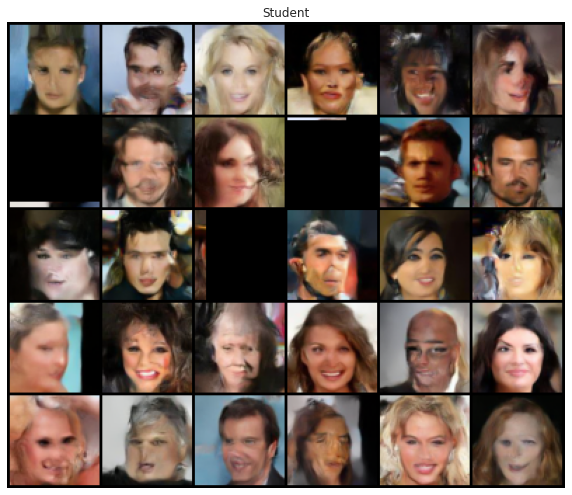

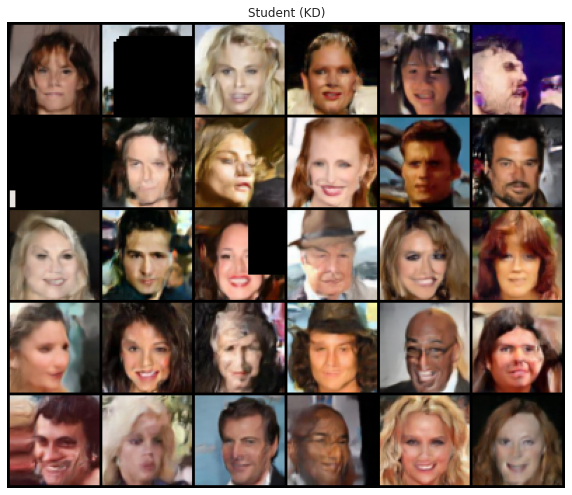

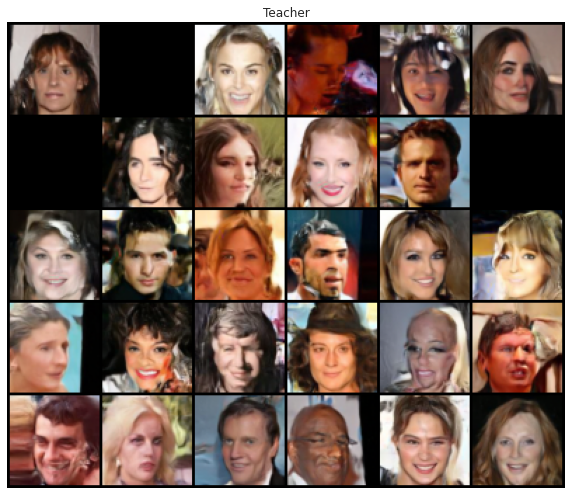

In [25]:
cur_samples = 0

samples = defaultdict(list)

for x, _ in tqdm(test_loader):
    x = x.to(device)
    student_latents = interpolate_latent(student, x)
    student_kd_latents = interpolate_latent(student_kd, x)
    teacher_latents = interpolate_latent(teacher, x)
    
    student_samples = generate(student, student_latents, temperature=0.7)
    student_kd_samples = generate(student_kd, student_kd_latents, temperature=0.7)
    teacher_samples = generate(teacher, teacher_latents, temperature=0.7)
    
    samples["student"].append(student_samples)
    samples["student_kd"].append(student_kd_samples)
    samples["teacher"].append(teacher_samples)
    
    cur_samples += x.size(0) // 2
    if cur_samples >= NUM_SAMPLES:
        break

grid = make_grid(student_samples[:30], nrow=6).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.title("Student")
plt.imshow(grid)
plt.axis("off")
plt.show()

grid = make_grid(student_kd_samples[:30], nrow=6).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.title("Student (KD)")
plt.imshow(grid)
plt.axis("off")
plt.show()

grid = make_grid(teacher_samples[:30], nrow=6).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.title("Teacher")
plt.imshow(grid)
plt.axis("off")
plt.show()

In [27]:
samples["student"] = torch.cat(samples["student"]).numpy()
samples["student_kd"] = torch.cat(samples["student_kd"]).numpy()
samples["teacher"] = torch.cat(samples["teacher"]).numpy()

samples["student"] = np.transpose(samples["student"], (0, 2, 3, 1))
samples["student_kd"] = np.transpose(samples["student_kd"], (0, 2, 3, 1))
samples["teacher"] = np.transpose(samples["teacher"], (0, 2, 3, 1))

In [28]:
student_fid_score = calculate_fid(
    real_data_for_fid,
    samples["student"],
    False,
    128,
    "/home/vdklyukin/nf_distillation/data/weights/inception_v3.pth",
)
student_fid_score

28.43212502125718

In [29]:
student_kd_fid_score = calculate_fid(
    real_data_for_fid,
    samples["student_kd"],
    False,
    128,
    "/home/vdklyukin/nf_distillation/data/weights/inception_v3.pth",
)
student_kd_fid_score

19.688866533737155

In [30]:
teacher_fid_score = calculate_fid(
    real_data_for_fid,
    samples["teacher"],
    False,
    128,
    "/home/vdklyukin/nf_distillation/data/weights/inception_v3.pth",
)
teacher_fid_score

16.381837924004373